# OfficeHome Dataset
- download from main page: https://www.hemanthdv.org/officeHomeDataset.html
- Subpopulation size
    - Majority: product domain (3965 images for 65 classes in total)
    - Minority: clipart domain (600 images for 65 classes in total)

In [1]:
ROOT_PATH = 'OfficeHomeDataset_10072016/' # downloaded dataset root path
EXP_ROOT_PATH = '../../experiments/officehome' # experiment root path

In [2]:
import os
import shutil
import numpy as np
import glob
from torchvision.datasets import ImageFolder

import pandas as pd
from tqdm import tqdm
from PIL import Image
import random
import matplotlib.pyplot as plt

In [4]:
info_csv = pd.read_csv(os.path.join(ROOT_PATH, 'ImageInfo.csv'))['name'].tolist()
img_list = [] # [domain, class, image name]
img_dict1 = {} # {domain: {class: [image_path, ...] } }
img_dict2 = {} # {domain: [[image_path, class_label], ... ] }
cls_idx = {}
for i in info_csv:
    img_list.append(i.split('/')[-3:])
for i in img_list:
    if i[1] == 'Clock':
        # !! 'Clock' class does not exist! might be labeled wrong, or confused with 'Alarm_Clock'
        continue 
    if i[0] not in img_dict1.keys():
        img_dict1[i[0]] = {}
    if i[1] not in img_dict1[i[0]].keys():
        img_dict1[i[0]][i[1]] = []
    img_dict1[i[0]][i[1]].append(os.path.join(ROOT_PATH, i[0], i[1], i[2]))
    
for d,dv in img_dict1.items():
    img_dict2[d] = []
    for ci, (c,cv) in enumerate(dv.items()):
        if c not in cls_idx.keys():
            cls_idx[c] = ci
        for img_path in cv:
            img_dict2[d].append([img_path, ci])
    random.Random(42).shuffle(img_dict2[d])

num_class = len(cls_idx)
domain_names = []
cls_num_list = {} # {class: [num,num,num,num] }, num of 4 domains for each class
for d,dv in img_dict1.items():
    domain_names.append(d)
    for c,cv in dv.items():
        if c not in cls_num_list.keys():
            cls_num_list[c] = []
        cls_num_list[c].append(len(cv))


## Dataset samples

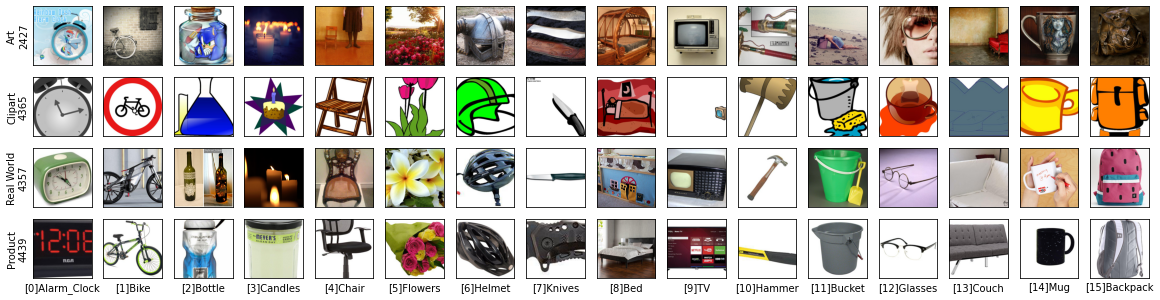

In [5]:
nline=16
plt.figure(figsize=(20,5))
for di,(d,dv) in enumerate(img_dict1.items()):
    for ci, (c,img_list) in enumerate(dv.items()):
        if ci<nline:
            plt.subplot(4,nline,di*nline+ci+1)
            img = Image.open(img_list[0])
            w,h = img.size
            s = min(w,h)
            img = img.crop(((w-s)/2,(h-s)/2,(w+s)/2,(h+s)/2))
            plt.imshow(img)
            plt.ylabel(d+'\n'+str(len(img_dict2[d]))) if ci==0 else None
            plt.xlabel('['+str(ci)+']'+c) if di==len(img_dict1)-1 else None
            plt.xticks([])
            plt.yticks([])
plt.show()

## Prepare data

In [ ]:
major_domain = 'Product'
minor_domain = 'Clipart'
TRAIN_NUM = [3965,800] # [majority, minority] in total
VAL_NUM   = [400,400] # [majority, minority] in total
print('majority : minority = {:.2f} : {:.2f}'.format(\
    TRAIN_NUM[0]/(TRAIN_NUM[0]+TRAIN_NUM[1]), TRAIN_NUM[1]/(TRAIN_NUM[0]+TRAIN_NUM[1])))

split_list = {'train':img_dict2[major_domain][:TRAIN_NUM[0]] + img_dict2[minor_domain][:TRAIN_NUM[1]], 
              'majority-val':img_dict2[major_domain][-VAL_NUM[0]:],
              'minority-val':img_dict2[minor_domain][-VAL_NUM[1]:]}

for dtype, data in split_list.items():
    random.Random(42).shuffle(data)
    
# Data Loading
DATA_ROOT_PATH = os.path.join(EXP_ROOT_PATH, 'data') 
if os.path.exists(DATA_ROOT_PATH) and os.path.isdir(DATA_ROOT_PATH):
    shutil.rmtree(DATA_ROOT_PATH)
os.makedirs(DATA_ROOT_PATH, exist_ok = False)

for k,v in split_list.items():
    for i_cls in range(num_class):
        os.makedirs(os.path.join(DATA_ROOT_PATH, k, str(i_cls)) , exist_ok = True)
    print(k)
    for si, sample in tqdm(enumerate(v)):
        if os.path.exists(sample[0]):
            pil_img = Image.open(sample[0])
            dst_path = os.path.join(DATA_ROOT_PATH, k, str(sample[1]), str(si)+'.jpg')
            pil_img.save(dst_path)
        else:
            print('[Not exist]',sample[0])